# MATH50003 (2023–24)
# Lab 5: III.1 Structured Matrices and III.2 Differential Equations

In this lab we explore the construction of vectors and matrices, in particular those with sparsity structure
such as triangular, diagonal, bidiagonal and tridiagonal
which we capture using special types. We also explore the reduction of differential equations to
banded linear systems via divided differences. When we get lower bidiagonal systems these can be solved
using forward substitution, whereas we will discuss the tridiagonal case later.

We first load  packages we need including a couple new ones:

In [111]:
# LinearAlgebra contains routines for doing linear algebra
using LinearAlgebra, Plots, Test

**Remark** One should normally not need to implement methods for solving differential equations
oneself as there are packages available, including the high-performance
 Julia package  [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl). Moreover Forward and Backward
Euler are only the first baby steps to a wide range of time-steppers, with Runge–Kutta being
one of the most successful.
For example, in practice we can solve
a simple differential equation like a pendulum $u'' = -\sin u$ can be solved
as follows (writing at a system $u' = v, v' = -\sin u$):

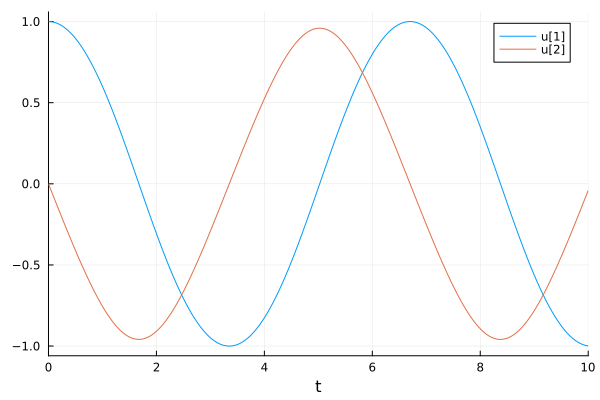

In [112]:
using DifferentialEquations, LinearAlgebra, Plots

u = solve(ODEProblem((u,_,x) -> [u[2], -sin(u[1])], [1,0], (0,10)))
plot(u)

However, even in these automated packages one has a choice of different methods with
different behaviour, so it is important to understand on a mathematical level what is happening under the hood.

**Learning Outcomes**

Mathematical knowledge:

1. Matrix multiplication, back- and forward-substitution.
2. Banded matrices and their utilisation for better complexity linear algebra.
2. Reduction of differential equations to bidiagonal or tridiagonal linear systems.
3. Two-point boundary value problems and their convergence rates.

Coding knowledge:

1. Construction of a dense `Vector` or `Matrix` either directly or via comprehensions or broadcasting.
2. The `vec`, `transpose`, `zeros`, `ones`, `fill`, `range`, `promote_type`, and `eltype` functions.
3. Using `\` to solve linear systems.
4. The `Diagonal`, `Bidiagonal`, and `Tridiagonal` types for making banded matrices.
5. Implementing a custom matrix type by subtyping `AbstractMatrix` and overloading `size`, `getindex`, and `setindex!`.

## III.1 Structured Matrices

Before discussing structured matrices we give an overview of creating arrays  (vectors and matrices)
in Julia.

### III.1.1 Dense matrices

One can create arrays in multiple ways. For example, the function `zeros(Int, 10)` creates
a 10-element `Vector` whose entries are all `zero(Int) == 0`. Or `fill(x, 10)` creates a
10-element `Vector` whose entries are all equal to `x`. Or you can use a comprehension:
for example `[k^2 for k = 1:10]` creates a vector whose entries are `[1^2, 2^2, …, 10^2]`.
This also works for matrices: `zeros(Int, 10, 5)` creates a 10 × 5 matrix of all zeros,
and `[k^2 + j for k=1:3, j=1:4]` creates the following:

In [113]:
[k^2 + j for k=1:3, j=1:4] # k is the row, j is the column

3×4 Matrix{Int64}:
  2   3   4   5
  5   6   7   8
 10  11  12  13

Note sometimes it is best to create a vector/matrix and populate it. For example, the
previous matrix could also been constructed as follows:

In [114]:
A = zeros(Int, 3, 4) # create a 3 × 4 matrix whose entries are 0 (as Ints)
for k = 1:3, j = 1:4
    A[k,j] = k^2 + j # set the entries of A
end
A

3×4 Matrix{Int64}:
  2   3   4   5
  5   6   7   8
 10  11  12  13

**Remark** Julia uses 0-based indexing where the first index of a vector/matrix
is 1. This is standard in all mathematical programming languages (Fortran, Maple, Matlab, Mathematica)
whereas those designed for computer science use 0-based indexing (C, Python, Rust).

Be careful: a `Matrix` or `Vector` can only ever contain entries of the right
type. It will attempt to convert an assignment to the right type but will throw
an error if not successful:

In [115]:
A[2,3] = 2.0 # works because 2.0 is a Float64 that is exactly equal to an Int
A[1,2] = 2.3 # fails since 2.3 is a Float64 that cannot be converted to an Int

InexactError: InexactError: Int64(2.3)

------
**Problem 1(a)** Create a 5×6 matrix whose entries are `Int` which is
one in all entries. Hint: use a for-loop, `ones`, `fill`, or a comprehension.

In [116]:
# TODO: Create a matrix of ones, 4 different ways
# SOLUTION

# 1. For-loop:

ret = zeros(Int, 5, 6)
for k = 1:5, j = 1:6
    ret[k,j] = 1
end
ret

# 2. Ones:

ones(Int, 5, 6)

# 3. Fill:

fill(1, 5, 6)

# 4. Comprehension:

[1 for k=1:5, j=1:6]


# END

5×6 Matrix{Int64}:
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1

**Problem 1(b)** Create a 1 × 5 `Matrix{Int}` with entries `A[k,j] = j`. Hint: use a for-loop or a comprehension.

In [117]:
# TODO: Create a 1 × 5  matrix whose entries equal the column, 2 different ways
# SOLUTION

# 1. For-loop

A = zeros(Int, 1, 5)
for j = 1:5
    A[1,j] = j
end

# 2. Comprehension

[j for k=1:1, j=1:5]

# There is also a third way:
# 3. convert transpose:

# Note: (1:5)' is a "row-vector" which behaves differently than a matrix
Matrix((1:5)')

# END

1×5 Matrix{Int64}:
 1  2  3  4  5

-------
#### Transposes and adjoints

We can also transpose a matrix `A` via `transpose(A)`
or compute the adjoint (conjugate-transpose) via `A'` (which is
equivalent to a transpose when the entries are real).
This is done _lazily_: they return custom types `Transpose` or
`Adjoint` that just wrap the input array and reinterpret the entries.
This is equivalent to
_row-major_ format, where the next address in memory of `transpose(A)` corresponds to
moving along the row.
Here is a simple example:

In [118]:
A = [1+im  2  3;
     4     5  6;
     6     8  9]

A' # adjoint (conjugate-transpose). If entries are real it is equivalent to transpose(A)

3×3 adjoint(::Matrix{Complex{Int64}}) with eltype Complex{Int64}:
 1-1im  4+0im  6+0im
 2+0im  5+0im  8+0im
 3+0im  6+0im  9+0im

If we change entries of `A'` it actually changes entries of `A` too since
they are pointing to the same locations in memory, just interpreting the data differently:

In [119]:
A'[1,2] = 2+im
A # A[2,1] is now 2-im

3×3 Matrix{Complex{Int64}}:
 1+1im  2+0im  3+0im
 2-1im  5+0im  6+0im
 6+0im  8+0im  9+0im

Note vector adjoints/transposes behave differently than 1 × n matrices: they are
more like row-vectors. For example the following computes the dot product of two vectors:

In [120]:
x = [1,2,3]
y = [4,5,6]
x'y # equivalent to dot(x,y), i.e. the standard dot product.

32

#### Broadcasting

_Broadcasting_ is a powerful and convenient way to create matrices or vectors,
where a function is applied to every entry of a vector or matrix.
By adding `.` to the end of a function we "broadcast" the function over
a vector:

In [121]:
x = [1,2,3]
cos.(x) # equivalent to [cos(1), cos(2), cos(3)], or can be written broadcast(cos, x)

3-element Vector{Float64}:
  0.5403023058681398
 -0.4161468365471424
 -0.9899924966004454

Broadcasting has some interesting behaviour for matrices.
If one dimension of a matrix (or vector) is `1`, it automatically
repeats the matrix (or vector) to match the size of another example.
In the following we use broadcasting to pointwise-multiply a column and row
vector to make a matrix:

In [122]:
a = [1,2,3]
b = [4,5]

a .* b'

3×2 Matrix{Int64}:
  4   5
  8  10
 12  15

Since `size([1,2,3],2) == 1` it repeats the same vector to match the size
`size([4,5]',2) == 2`. Similarly, `[4,5]'` is repeated 3 times. So the
above is equivalent to:

In [123]:
A = [1 1;
     2 2;
     3 3] # same as [a a], i.e. repeat the vector a in each column
B = [4 5;
     4 5;
     4 5] # same as [b'; b' b'], i.e. repeat the row vector b' in each row

A .* B # equals the above a .* b'

3×2 Matrix{Int64}:
  4   5
  8  10
 12  15

Note we can also use matrix broadcasting with our own functions:

In [124]:
f = (x,y) -> cos(x + 2y)
f.(a, b') # makes a matrix with entries [f(1,4) f(1,5); f(2,4) f(2,5); f(3,4) f(3.5)]

3×2 Matrix{Float64}:
 -0.91113    0.0044257
 -0.839072   0.843854
  0.0044257  0.907447

#### Ranges

_Ranges_ are another useful example of vectors, but where the entries are defined "lazily" instead of
actually created in memory.
We have already seen that we can represent a range of integers via `a:b`. Note we can
convert it to a `Vector` as follows:

In [125]:
Vector(2:6)

5-element Vector{Int64}:
 2
 3
 4
 5
 6

We can also specify a step:

In [126]:
Vector(2:2:6), Vector(6:-1:2)

([2, 4, 6], [6, 5, 4, 3, 2])

Finally, the `range` function gives more functionality, for example, we can create 4 evenly
spaced points between `-1` and `1`:

In [127]:
Vector(range(-1, 1; length=4))

4-element Vector{Float64}:
 -1.0
 -0.3333333333333333
  0.3333333333333333
  1.0

Note that `Vector` is mutable but a range is not:

In [128]:
r = 2:6
r[2] = 3   # Not allowed

CanonicalIndexError: CanonicalIndexError: setindex! not defined for UnitRange{Int64}

Both ranges `Vector` are subtypes of `AbstractVector`, whilst `Matrix` is a subtype of `AbstractMatrix`.

-----

**Problem 1(c)** Create a vector of length 5 whose entries are `Float64`
approximations of `exp(-k)`. Hint: use a for-loop, broadcasting `f.(x)` notation, or a comprehension.

In [129]:
# TODO: Create a vector whose entries are exp(-k), 3 different ways
# SOLUTION

# 1. For-loop
v = zeros(5) # defaults to Float64
for k = 1:5
    v[k] = exp(-k)
end

# 2. Broadcast:
exp.(-(1:5))

# we can also do this explicitly
broadcast(k -> exp(-k), 1:5)

# 4. Comprehension:
[exp(-k) for k=1:5]


# END

5-element Vector{Float64}:
 0.36787944117144233
 0.1353352832366127
 0.049787068367863944
 0.01831563888873418
 0.006737946999085467

------
#### Storage of matrices and vectors

A `Vector` stores its entries consecutively in memory.
To be perhaps overly technical: a `Vector` contains a "pointer" (an integer)
to the first memory address and a length. A `Matrix` is also stored consecutively in memory
 going down column-by-
column (_column-major_). That is,

In [130]:
A = [1 2;
     3 4;
     5 6]

3×2 Matrix{Int64}:
 1  2
 3  4
 5  6

Is actually stored equivalently to a length `6` vector `[A[1,1],A[2,1],A[3,1],A[1,2],A[2,2],A[3,2]]`:

In [131]:
vec(A)

6-element Vector{Int64}:
 1
 3
 5
 2
 4
 6

which in this case would be stored using `8 * 6 = 48` consecutive bytes.
Behind the scenes, a matrix is also "pointer" to the location of the first entry alongside two integers
dictating the row and column sizes.

Matrix-vector multiplication works as expected because `*` is overloaded:

In [132]:
x = [7, 8]
A * x

3-element Vector{Int64}:
 23
 53
 83

We can implement our own version for any types that support `*` and `+` but there are
actually two different ways. The most natural mathematical way is to multiply-by-rows:

In [133]:
function mul_rows(A, x)
    m,n = size(A)
    # promote_type type finds a type that is compatible with both types, eltype gives the type of the elements of a vector / matrix
    T = promote_type(eltype(x), eltype(A))
    c = zeros(T, m) # the returned vector, begins of all zeros
    for k = 1:m # for each column
        for j = 1:n # then each row
            c[k] += A[k, j] * x[j] # equivalent to c[k] = c[k] + A[k, j] * x[j]
        end
    end
    c
end

mul_rows (generic function with 1 method)

But we can also change the order of operations to give an alternative approach that is multiply-by-columns:

In [134]:
function mul_cols(A, x)
    m,n = size(A)
    # promote_type type finds a type that is compatible with both types, eltype gives the type of the elements of a vector / matrix
    T = promote_type(eltype(x), eltype(A))
    c = zeros(T, m) # the returned vector, begins of all zeros
    for j = 1:n # for each column
        for k = 1:m # then each row
            c[k] += A[k, j] * x[j] # equivalent to c[k] = c[k] + A[k, j] * x[j]
        end
    end
    c
end

mul_cols (generic function with 3 methods)

Both implementations match _exactly_ for integer inputs:

In [135]:
mul_rows(A, x), mul_cols(A, x) # also matches `A*x`

([23, 53, 83], [23, 53, 83])

Either implementation will be $O(mn)$ operations. However, the implementation
`mul_cols` accesses the entries of `A` going down the column,
which happens to be _significantly faster_ than `mul_rows`, due to accessing
memory of `A` in order. We can see this by measuring the time it takes using `@btime`:

In [136]:
n = 1000
A = randn(n,n) # create n x n matrix with random normal entries
x = randn(n) # create length n vector with random normal entries

using BenchmarkTools # load package for reliable timing
@btime mul_rows(A,x)
@btime mul_cols(A,x)
@btime A*x; # built-in, high performance implementation. USE THIS in practice

  907.166 μs (1 allocation: 7.94 KiB)


  389.125 μs (1 allocation: 7.94 KiB)


  89.000 μs (1 allocation: 7.94 KiB)


Here `ms` means milliseconds (`0.001 = 10^(-3)` seconds) and `μs` means microseconds (`0.000001 = 10^(-6)` seconds).
On my machine we observe that `mul_cols` is roughly 2–3x faster than `mul_rows`, while the optimised `*` is roughly 5x faster than `mul_cols`.
The reason why isn't too important for us (accessing memory in order is much faster than jumping around), but the key points are:
1. Making fast algorithms is delicate and arguably more of an art than a science.
2. We can focus on complexity rather than counting operations as the latter does not tell us speed.
3. Use in-built implementations whenever available.

Note that the rules of floating point arithmetic apply here. Matrix multiplication with floats
will incur round-off error (the precise details of which are subject to the implementation):

In [137]:
A = [1.4 0.4;
     2.0 1/2]
A * [1, -1] # First entry has round-off error, but 2nd entry is exact

2-element Vector{Float64}:
 0.9999999999999999
 1.5

And integer arithmetic will be subject to overflow:

In [138]:
A = fill(Int8(2^6), 2, 2) # make a matrix whose entries are all equal to 2^6
A * Int8[1,1] # we have overflowed and get a negative number -2^7

2-element Vector{Int8}:
 -128
 -128

Solving a linear system is done using `\`:

In [139]:
A = [1 2 3;
     1 2 4;
     3 7 8]
b = [10; 11; 12]
A \ b

3-element Vector{Float64}:
  41.00000000000001
 -17.000000000000004
   1.0

Despite the answer being integer-valued,
here we see that it resorted to using floating point arithmetic,
incurring rounding error.
But it is "accurate to (roughly) 16-digits".
As we shall see, the way solving a linear system works is we first write `A` as a
product of matrices that are easy to invert, e.g., a product of triangular matrices or a product of an orthogonal
and triangular matrix.

### III.1.2 Triangular Matrices

Triangular matrices are represented by dense square matrices where the entries below the
diagonal are ignored:

In [140]:
A = [1 2 3;
     4 5 6;
     7 8 9]
L = LowerTriangular(A)

3×3 LowerTriangular{Int64, Matrix{Int64}}:
 1  ⋅  ⋅
 4  5  ⋅
 7  8  9

We can see that `L` is storing all the entries of `A` in a field called `data`:

In [141]:
L.data

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

Similarly we can create an upper triangular matrix by ignoring the entries below the diagonal:

In [142]:
U = UpperTriangular(A)

3×3 UpperTriangular{Int64, Matrix{Int64}}:
 1  2  3
 ⋅  5  6
 ⋅  ⋅  9

If we know a matrix is triangular we can do matrix-vector multiplication in roughly half
the number of operations by skipping over the entries we know are zero:

In [143]:
function mul_cols(L::LowerTriangular, x)
    n = size(L,1)
    # promote_type type finds a type that is compatible with both types, eltype gives the type of the elements of a vector / matrix
    T = promote_type(eltype(x),eltype(L))
    b = zeros(T, n) # the returned vector, begins of all zeros
    for j = 1:n
        xⱼ = x[j]
        for k = j:n # k = j:n instead of 1:n since we know L[k,j] = 0 if k < j.
            b[k] += L[k, j] * xⱼ
        end
    end
    b
end

x = [10, 11, 12]
# matches built-in * which also exploits the structure:
@test mul_cols(L, x) == L*x

Test Passed

Moreover, we can easily invert matrices.
Consider a simple 3×3 example, which can be solved with `\`:

In [144]:
b = [5, 6, 7]
x = L \ b # Excercise: why does this return a float vector?

3-element Vector{Float64}:
  5.0
 -2.8
 -0.6222222222222223

Behind the scenes, `\` is doing forward-substitution.
We can implement our own version as follows:

In [145]:
# ldiv is our own version of \
function ldiv(L::LowerTriangular, b)
    n = size(L,1)

    if length(b) != n
        error("The system is not compatible")
    end

    x = zeros(n)  # the solution vector
    for k = 1:n  # start with k = 1
        r = b[k]  # dummy variable
        for j = 1:k-1
            r -= L[k,j]*x[j]
        end
        x[k] = r/L[k,k]
    end
    x
end


@test ldiv(L, b) ≈ L\b

Test Passed

------

**Problem 3(a)** Complete the following function for upper triangular matrix-vector
multiplication without ever accessing the zero entries of `L` above the diagonal.
You may assume all numbers are `Float64`.
Hint: just copy code for `mul_cols` and modify the for-loop ranges a la the `UpperTriangular`
case.

In [146]:
function mul_cols(U::UpperTriangular, x)
    n = size(U,1)

    b = zeros(n) # the returned vector, begins of all zeros

    # TODO: populate b so that U*x ≈ b
    # SOLUTION
    for j = 1:n, k = 1:j
        b[k] += U[k, j] * x[j]
    end
    # END

    b
end

U = UpperTriangular(randn(5,5))
x = randn(5)
@test U*x ≈ mul_cols(U, x)

Test Passed

**Problem 3(b)** Complete the following function for solving linear systems with
upper triangular systems by implementing back-substitution. You may assume
all input and output vectors have `Float64` values.

In [147]:
# ldiv(U, b) is our implementation of U\b
function ldiv(U::UpperTriangular, b)
    n = size(U,1)

    if length(b) != n
        error("The system is not compatible")
    end

    x = zeros(n)  # the solution vector
    # TODO: populate x with the entries according to back substitution.
    # SOLUTION
    for k = n:-1:1  # start with k=n, then k=n-1, ...
        r = b[k]  # dummy variable
        for j = k+1:n
            r -= U[k,j]*x[j] # equivalent to r = r - U[k,j]*x[j]
        end
        # after this for loop, r = b[k] - ∑_{j=k+1}^n U[k,j]x[j]
        x[k] = r/U[k,k]
    end
    # END
    x
end


U = UpperTriangular(randn(5,5))
b = randn(5)
@test U\b ≈ ldiv(U, b)

Test Passed

## III.1.3 Banded matrices

Diagonal matrices in Julia are stored as a vector containing the diagonal entries:

In [148]:
x = [1,2,3]
D = Diagonal(x) # the type Diagonal has a single field: D.diag

3×3 Diagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅
 ⋅  2  ⋅
 ⋅  ⋅  3

It is clear that we can perform diagonal-vector multiplications and solve linear systems involving diagonal matrices efficiently
(in $O(n)$ operations).

We can create bidiagonal matrices in Julia by specifying the diagonal and off-diagonal:

In [149]:
L = Bidiagonal([1,2,3], [4,5], :L) # the type Bidiagonal has three fields: L.dv (diagonal), L.ev (lower-diagonal), L.uplo (either 'L', 'U')

3×3 Bidiagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅
 4  2  ⋅
 ⋅  5  3

In [150]:
U = Bidiagonal([1,2,3], [4,5], :U) # When U.uplo == 'U' it is interpreted as an upper bidiagonal matrix

3×3 Bidiagonal{Int64, Vector{Int64}}:
 1  4  ⋅
 ⋅  2  5
 ⋅  ⋅  3

Multiplication and solving linear systems with Bidiagonal systems is also $O(n)$ operations, using the standard
multiplications/back-substitution algorithms but being careful in the loops to only access the non-zero entries.

Julia has a type `Tridiagonal` for representing a tridiagonal matrix from its sub-diagonal, diagonal, and super-diagonal:

In [151]:
T = Tridiagonal([1,2], [3,4,5], [6,7]) # The type Tridiagonal has three fields: T.dl (sub), T.d (diag), T.du (super)

3×3 Tridiagonal{Int64, Vector{Int64}}:
 3  6  ⋅
 1  4  7
 ⋅  2  5

Tridiagonal matrices will come up in solving second-order differential equations and orthogonal polynomials.
We will later see how linear systems involving tridiagonal matrices can be solved in $O(n)$ operations.

-----

**Problem 4(a)** Complete the implementation of `UpperTridiagonal` which represents a banded matrix with
bandwidths $(l,u) = (0,2)$ by overloading `getindex(U::UpperTridiagonal, k::Int, j::Int)` (which implements `U[k,j]`) and `setindex!(U::UpperTriangular, v, k::Int, j::Int)` (which implements `U[k,j] = v`). Return zero (of the same type as the other entries)
if we are off the bands.

In [152]:
struct UpperTridiagonal <: AbstractMatrix{Float64}
    d   # diagonal entries stored as a Vector: d[k] == U[k,k]
    du  # super-diagonal enries stored as a Vector: du[k] == U[k,k+1]
    du2 # second-super-diagonal entries stored as a Vector: du2[k] == U[k,k+2]
end

# This uses the notation `<: AbstractMatrix{Float64}`: this tells Julia that our type is in fact a matrix
# whose entries are `Float64`.
# In order for it to behave a matrix we have to overload the function `size` for our type to return
# the dimensions (in this case we just use the length of the diagonal):

import Base: size, getindex, setindex!

size(U::UpperTridiagonal) = (length(U.d),length(U.d))

# Julia still doesn't know what the entries of the matrix are. To do this we need to overload `getindex`.
# We also overload `setindex!` to allow changing the non-zero entries.


# getindex(U, k, j) is another way to write U[k,j].
# This function will therefore be called when we call U[k,j]
function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    # TODO: return U[k,j]
    # SOLUTION
    if j == k+2
    	return U.du2[k]
    elseif j == k+1
    	return U.du[k]
    elseif j == k
    	return U.d[k]
    else # off band entries are zero
    	return 0.0
    end
    # END
end

# setindex!(U, v, k, j) gets called when we write (U[k,j] = v).
function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j > k+2 || j < k
        error("Cannot modify off-band")
    end

    # TODO: modify d,du,du2 so that U[k,j] == v
    # SOLUTION
    if j == k+2
    	du2[k] = v
    elseif j == k+1
    	du[k] = v
    elseif j == k
    	d[k] = v
    end
    # END
    U # by convention we return the matrix
end

U = UpperTridiagonal([1.0,2,3,4,5], [1.0,2,3,4], [1.0,2,3])
@test U == [1 1 1 0 0;
            0 2 2 2 0;
            0 0 3 3 3;
            0 0 0 4 4;
            0 0 0 0 5]

U[3,4] = 2
@test U == [1 1 1 0 0;
            0 2 2 2 0;
            0 0 3 2 3;
            0 0 0 4 4;
            0 0 0 0 5]

Test Passed

**Problem 4(b)** Complete the following implementations of `*` and `\` for `UpperTridiagonal` so that
they take only $O(n)$ operations. Hint: the function `max(a,b)` returns the larger of `a` or `b`
and `min(a,b)` returns the smaller. They may help to avoid accessing zeros.

In [153]:
import Base: *, \

function *(U::UpperTridiagonal, x::AbstractVector)
    n = size(U,1)
    b = zeros(n) # the returned vector, assume Float64 values
    # TODO: populate b so that U*x ≈ b (up to rounding)
    # SOLUTION
    for j = 1:n, k = max(j-2,1):j
        b[k] += U[k, j] * x[j]
    end
    # END
    b
end

function \(U::UpperTridiagonal, b::AbstractVector)
    n = size(U,1)
    if length(b) != n
        error("The system is not compatible")
    end

    x = zeros(n)  # the solution vector, assume Float64 values
    # TODO: populate x so that U*x ≈ b
    # SOLUTION
    for k = n:-1:1  # start with k=n, then k=n-1, ...
        r = b[k]  # dummy variable
        for j = k+1:min(n, k+2)
            r -= U[k,j]*x[j] # equivalent to r = r - U[k,j]*x[j]
        end
        # after this for loop, r = b[k] - ∑_{j=k+1}^n U[k,j]x[j]
        x[k] = r/U[k,k]
    end
    # END
    x
end

n = 1_000_000 # under-scores are like commas: so this is a million: 1,000,000
U = UpperTridiagonal(ones(n), fill(0.5,n-1), fill(0.1,n-2))
x = ones(n)
b = [fill(1.6,n-2); 1.5; 1] # exact result
# note following should take much less than a second
@test U*x ≈ b
@test U\b ≈ x

Test Passed

## III.2 Differential Equations via Finite Differences

We now turn to an important application of banded linear algebra:
approximating solutions to linear differential equations. We will focus on first and second order
but the techniques generalise beyond this, to vector problems, nonlinear differential equations, and partial differential equations.
In particular we explore _finite difference_ approximations which use divided differences to replace derivatives.
These are the most basic type of numerical method and many powerful alternatives
exist, including Finite Element Methods and spectral methods.

### III.2.1 Indefinite integration

We can use the right-sided divided difference to approximate derivatives.  Let's do an example of integrating $\cos x$ by discretising the ODE
$$
 u(0) = c, \qquad u'(x) = f(x)
$$
and see if our method matches
the true answer of $\sin x$. Recall from the notes that this equation can be approximated by $u_k$ solving the bidiagonal linear system
$$
\begin{bmatrix}
    1 \\
    -1/h & 1/h \\
    & ⋱ & ⋱ \\
    && -1/h & 1/h \end{bmatrix} \begin{bmatrix}u_0\\u_1\\⋮\\u_n\end{bmatrix} = \begin{bmatrix}c\\ f(x_0)\\ ⋮ \\ f(x_{n-1})\end{bmatrix}.
$$
We can construct the bidiagonal matrix as follows:

In [154]:
n = 10
x = range(0, 1; length=n+1) # makes an n+1 point evenly spaced grid
h = step(x) # equivalent to 1/n
L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)

11×11 Bidiagonal{Float64, Vector{Float64}}:
   1.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
 -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0     ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0    ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0  10.0

We can use this bidiagonal matrix along with `\` to solve the
system via forward substitution:

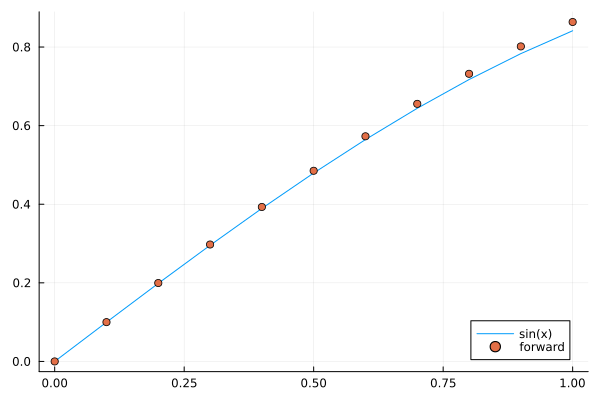

In [155]:
c = 0 # u(0) = 0
f = x -> cos(x)

𝐟 = f.(x[1:end-1]) # evaluate f at all but the last point
𝐛 = [c; 𝐟]
𝐮 = L \ 𝐛 # integrate using forward-differences

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, 𝐮; label="forward")

 We can estimate how fast it converges by measuring
the ∞-norm error (using $\| 𝐱 \|_∞ := \max |x_k|$ which
is implemented as `norm(x,Inf)`):

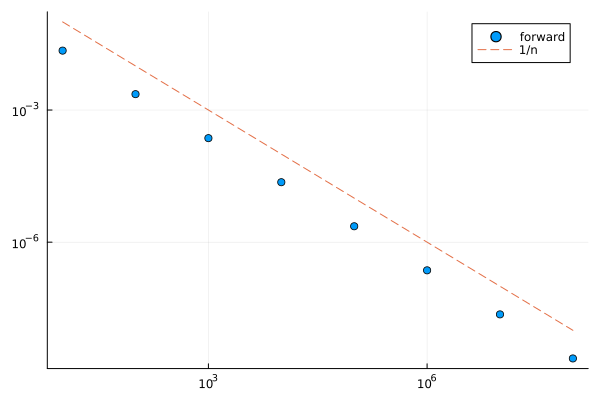

In [156]:
# Error from indefinite integration with c and f
function forward_err(u, c, f, n)
    x = range(0, 1; length = n+1)
    h = step(x) # equivalent to 1/n
    L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)
    𝐮 = L\ [c; f.(x[1:end-1])]
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf) # measure ∞-norm error
end


ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, forward_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="forward")
plot!(ns, ns .^ (-1); label="1/n", linestyle=:dash)

We see that the method converges linearly (like $O(n^{-1})$).

------

**Problem 5(a)** Implement Backward Euler as derived in the problem sheet to approximate
indefinite-integration. How does the error compare to forward
for $f(x) = \cos x$ on the interval $[0,1]$?
Use the method to approximate the indefinite intergral of
$$
\exp(\exp x \cos x + \sin x)
$$
to 3 digits.

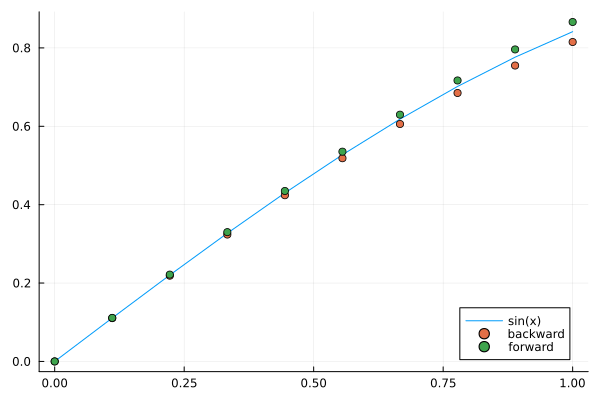

In [157]:
# TODO: Implement Backward Euler by constructing a lower bidiagonal linear system.
# SOLUTION

# To help with understanding we will also plot the errors even though this
# wasn't asked for in the question. We first compare backward and forward Euler:
c = 0 # u(0) = 0
f = x -> cos(x)
n = 10

x = range(0,1;length=n)
h=step(x)
A = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
ub = A\[c; f.(x[2:end])]
uf = A \ [c; f.(x[1:end-1])]

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, ub; label="backward")
scatter!(x, uf; label="forward")

In [158]:
# Comparing each method's errors, we see that the backward method has the same error as the forward method:


function forward_err(u, c, f, n)
    x = range(0, 1; length = n+1)
    h = step(x) # equivalent to 1/n
    L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)
    𝐮 = L\ [c; f.(x[1:end-1])]
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf) # measure ∞-norm error
end

function back_err(u, c, f, n)
    x = range(0,1;length=n)
    h=step(x)
    A = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
    ub = A\[c; f.(x[2:end])]
    norm(ub - u.(x), Inf)
end

c = 0 # u(0) = 0
f = x -> cos(x)
m = (x[1:end-1] + x[2:end])/2 # midpoints
ns = 10 .^ (1:8) # solve up to n = 10 million


scatter(ns, forward_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="forward")
scatter!(ns, back_err.(sin, 0, f, ns); label="back",alpha=0.5)
plot!(ns, ns .^ (-1); label="1/n")
plot!(ns, ns .^ (-2); label="1/n^2")


# Finally we get to the last part. One can increase n until
# 3 digits don't change. Or we can use the fact that the rate of convergence
# is O(n^(-1)) and guess that n = 100k suffices.


c = 0 # u(0) = 0
n = 100_000

#functions defined in the solutions to problem sheet 2
f = x -> exp(exp(x)cos(x) + sin(x))

x = range(0,1;length=n)
h=step(x)
A = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
uf = A\[c; f.(x[2:end])]

uf_int = uf[end]

println(uf_int)

# END

6.79536893556042


**Problem 5(b)** Implement indefinite-integration
where we impose the equation on the midpoints $x̃_1,…,x̃_n$ defined as
$$
x̃_j = {x_{j+1} + x_j \over 2} = a + (j+1/2)h
$$
using the central difference formula
$$
u'(x̃_j) ≈ {u(x_j) - u(x_{j-1}) \over h}
$$
By plotting the errors show that this method converges at
a faster rate than Forward or Backward Euler for $f(x) = \cos x$ on the interval $[0,1]$.

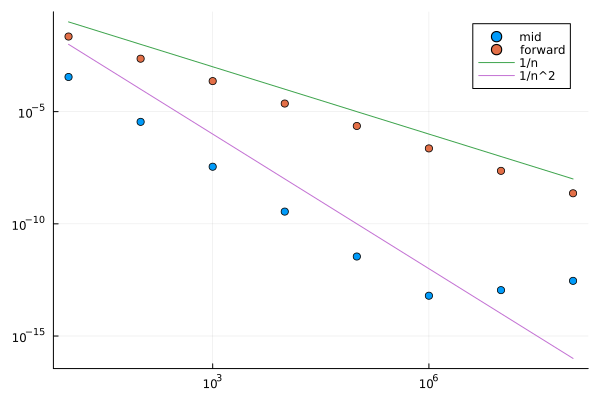

In [159]:
# TODO: Discretise at midpoints rather than our grid. The solution is still approximated on the original grid.
# SOLUTION


# The system is identical to before, just we evaluate the
# right-hand side at the midpoints.

n = 10
x = range(0, 1; length=n+1)
h = step(x)
A = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)
c = 0 # u(0) = 0
f = x -> cos(x)

x̃ = (x[2:end] + x[1:end-1])/2
𝐟 = f.(x̃) # evaluate f at all but last points
𝐮 = A \ [c; 𝐟]

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, 𝐮; label="average grid point")





# Comparing the error to the midpoint method, we see that the errors are very similar:

function mid_err(u, c, f, n)
    x = range(0, 1; length = n+1)
    h = step(x) # equivalent to 1/n
    L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)
    x̃ = (x[2:end] + x[1:end-1])/2
    𝐟 = f.(x̃) # evaluate f at all but last points

    𝐮 = L\ [c; 𝐟]
    errs = 𝐮 - u.(x) # compare numerics with "true" result
    norm(errs, Inf) # measure ∞-norm error
end

c = 0 # u(0) = 0
f = x -> cos(x)
ns = 10 .^ (1:8) # solve up to n = 10 million


scatter(ns, mid_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="mid")
scatter!(ns, forward_err.(sin, 0, f, ns); label="forward")
plot!(ns, ns .^ (-1); label="1/n")
plot!(ns, ns .^ (-2); label="1/n^2")
# The error now decreases quadratically. Interestingly: we do not see
# the same growth in error as we did for computing derivatives. That is:
# solving an ODE is a more stable process than applying a differential operator.
# END

----

### III.2.2 Forward Euler

We now adapt the approach for more general ODEs of the form
$$
  u'(x) + ω(x)u(x) = f(x), u(0) = c.
$$
We now have the system:
$$
\underbrace{\begin{bmatrix}
1 \\
ω(x_0)-1/h & 1/h \\
& ⋱ & ⋱ \\
&& ω(x_{n-1})-1/h & 1/h \end{bmatrix}}_L \underbrace{\begin{bmatrix}u_0 \\ u_1 \\ ⋮ \\ u_n\end{bmatrix} }_{𝐮} = \begin{bmatrix} c \\ f(x_0) \\ ⋮ \\ f(x_{n-1}) \end{bmatrix}
$$
Consider the simple example:
 $$
 u(0) = 1, u' + x u = {\rm e}^x
 $$
 which has an exact solution in terms of a special error function
 (which I determined using Mathematica).

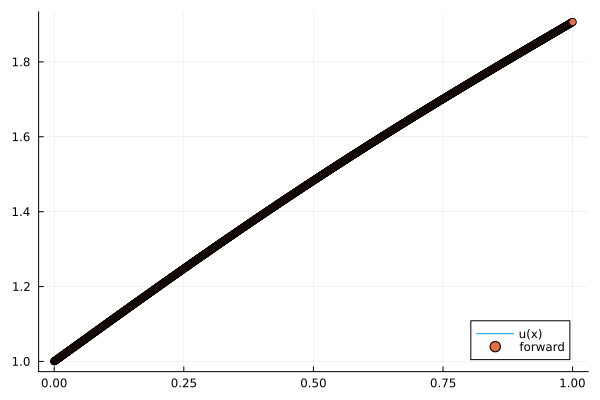

In [160]:
using SpecialFunctions
c = 1
ω = x -> x
n = 2000
x = range(0, 1; length=n)
# exact solution, found in Mathematica
u = x -> -(1/2)*exp(-(1+x^2)/2)*(-2sqrt(ℯ) + sqrt(2π)erfi(1/sqrt(2)) - sqrt(2π)erfi((1 + x)/sqrt(2)))

h = step(x)
L = Bidiagonal([1; fill(1/h, n-1)], ω.(x[1:end-1]) .- 1/h, :L)

𝐛 = [c; exp.(x[1:end-1])]
𝐮 = L \ 𝐛

plot(x, u.(x); label="u(x)", legend=:bottomright)
scatter!(x, 𝐮; label="forward")

We see that it is converging to the true result.

----

**Problem  6** Implement backward Euler for solving:
$$
\begin{align*}
u(0) &= 1, u'(t) - \cos(t) u(t) = t
\end{align*}
$$
If we increase the initial condition $w(0) = c > 1$, $w'(0)$
the solution may blow up in finite time. Find the smallest positive integer $c$
such that the numerical approximation suggests the equation
does not blow up.

In [161]:
# TODO: Implement backward Euler for the case with a variable coefficient.

# SOLUTION

function first_eq(n)
    #this function takes n and returns the estimate of u(1) using n steps
    #define the range of t
    t = range(0, 1; length=n)
    #find the step-size h
    h = step(t)

    #preallocate memory
    u = zeros(n)
    #set initial condition
    u[1] = 1
    for k=1:n-1
       u[k+1] = (1+h*cos(t[k]))*u[k] + h*t[k]
    end
    u[end]
end
ns = 2 .^ (1:13)
println(first_eq.(ns)')

# We see that $u(1) = 2.96$ to three digits.

# END

[2.0 2.5750568981571456 2.7887231159522656 2.881824999955957 2.9254124926170757 2.9465162316784763 2.9569015164393777 2.962053226375413 2.964618935882748 2.96589926513106 2.966538799730441 2.966858409692436 2.967018175359888]


-----

### III.2.3 Poisson equation

We now consider the Poisson equation with Dirichlet
boundary conditions. In particular consider a case where
we know the true answer: if $u(x) = \cos x^2$ then it solves the ODE:
$$
\begin{align*}
u(0) = \underbrace{1}_c \\
u''(x) = \underbrace{-4x^2 \cos(x^2) - 2\sin(x^2)}_{f(x)} \\
u(1) = \underbrace{\cos 1}_d
\end{align*}
$$
We approximate it by the solution to the tridiagonal system:
$$
\underbrace{\begin{bmatrix}
    1 \\
    1/h^2 & -2/h^2 & 1/h \\
    & ⋱ & ⋱ & ⋱ \\
   && 1/h^2 & -2/h^2 & 1/h \\
   &&&& 1 \end{bmatrix}}_A \underbrace{\begin{bmatrix}u_0\\u_1\\⋮\\u_n\end{bmatrix} }_{𝐮} = \underbrace{\begin{bmatrix}c\\ f(x_0)\\ f(x_1)\\ ⋮ \\ f(x_{n-1})\\ d\end{bmatrix} }_{𝐛}
$$
We first construct the matrix $A$ using `Tridiagonal`:

In [162]:
n = 20
x = range(0, 1; length = n + 1)
h = step(x)
A = Tridiagonal([fill(1/h^2, n-1); 0],
                [1; fill(-2/h^2, n-1); 1],
                [0; fill(1/h^2, n-1)])

21×21 Tridiagonal{Float64, Vector{Float64}}:
   1.0     0.0      ⋅       ⋅       ⋅   …      ⋅       ⋅       ⋅      ⋅ 
 400.0  -800.0   400.0      ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅    400.0  -800.0   400.0      ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅    400.0  -800.0   400.0         ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅    400.0  -800.0         ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅    400.0  …      ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
   ⋮                                    ⋱                            ⋮
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅   

Thus we get an approximation to our (known) solution:

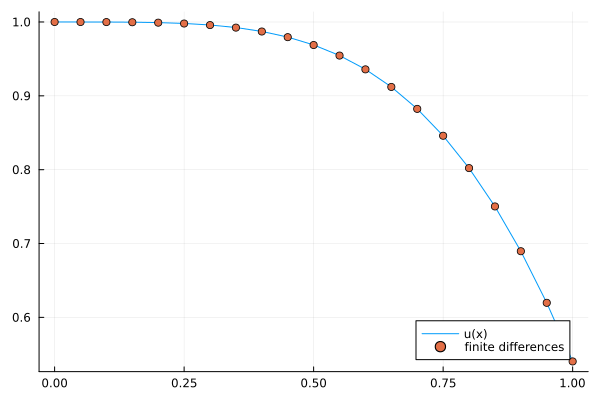

In [163]:
u = x -> cos(x^2)
f = x -> -4x^2*cos(x^2) - 2sin(x^2)
𝐛 =  [1; f.(x[2:end-1]); cos(1)]
𝐮 = A \ 𝐛
plot(x, u.(x); label="u(x)", legend=:bottomright)
scatter!(x, 𝐮; label="finite differences")

-----

**Problem 7(a)** Estimate the rate of convergence in the ∞-norm using the previous example with an increasing number of grid points.

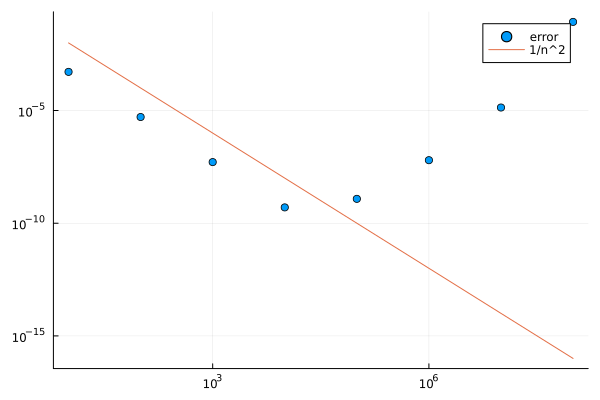

In [164]:
# TODO: Plot the ∞-norm error and estimate the convergence rate.
# SOLUTION

function poisson_err(u, c_0, c_1, f, n)
    x = range(0, 1; length = n+1)
    h = step(x)
    T = Tridiagonal([fill(1/h^2, n-1); 0], [1; fill(-2/h^2, n-1); 1], [0; fill(1/h^2, n-1)])
    uᶠ = T \ [c_0; f.(x[2:end-1]); c_1]
    norm(uᶠ - u.(x), Inf)
end



ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, poisson_err.(u, 1, cos(1), f, ns); xscale=:log10, yscale=:log10, label="error")
plot!(ns, ns .^ (-2); label="1/n^2")
# END

**Problem 7(b)** Construct a finite-difference approximation to the
forced Helmholtz equation
$$
\begin{align*}
u(0) &= 0 \\
u(1) &= 0 \\
u'' + k^2 u &= {\rm e}^x
\end{align*}
$$
and find an $n$ such  the error is less than $10^{-4}$ when compared
with the true solution for $k=10$:
$$
u(x) = (-\cos(k x) + {\rm e}^x \cos(k x)^2 + \cot(k) \sin(k x) - {\rm e} \cos(k) \cot(k) \sin(k x) - {\rm e} \sin(k) \sin(k x) + {\rm e}^x \sin(k x)^2)/(1 + k^2)
$$

In [165]:
# TODO: Generalise the second-order finite differences to allow for a $k^2 u$ term.

# SOLUTION
## We do something slightly different and use SymTridiagonal.
# You can also do this with Tridiagonal
function helm(k, n)
    x = range(0, 1; length = n+1)
    h = step(x)
    T = SymTridiagonal(ones(n-1)*(-2/h^2 + k^2),ones(n-2)*1/h^2)
    u = T \ exp.(x[2:end-1])
    [0; u; 0]
end

k = 10
u = x -> (-cos(k*x) + exp(x)cos(k*x)^2 + cot(k)sin(k*x) - ℯ*cos(k)cot(k)sin(k*x) - ℯ*sin(k)sin(k*x) + exp(x)sin(k*x)^2)/(1 + k^2)

n = 2048
x = range(0, 1; length=n+1)
@test norm(helm(k, n) - u.(x)) ≤ 1E-4
# END

Test Passed

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*